In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import db
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s

In [2]:
DATA_PATH = "data/laurier/"
DATA_BASE = DATA_PATH + "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "laurier.jpg"
VIDEO_PATH = DATA_PATH + "laurier.avi"
HOMOGRAPHY = DATA_PATH + "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

In [2]:
DATA_PATH = "data/grl/"
DATA_BASE = DATA_PATH + "grl.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "grl.png"
VIDEO_PATH = DATA_PATH + "grl.MOV"
HOMOGRAPHY = DATA_PATH + "homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

In [3]:
nb_trajectories_per_object = 2

trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)
pixel_trajectories_po = [[ut.to_pixel(t,HOMOGRAPHY) for t in trajectories] for trajectories in trajectories_po]

nb_trajectories = nb_trajectories_per_object * nb_objects

trajectories = [t for o in trajectories_po for t in o]
ids = [i for o in ids_po for i in o]
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories]


In [5]:
nb_objects

5

In [6]:
nb_trajectories

10

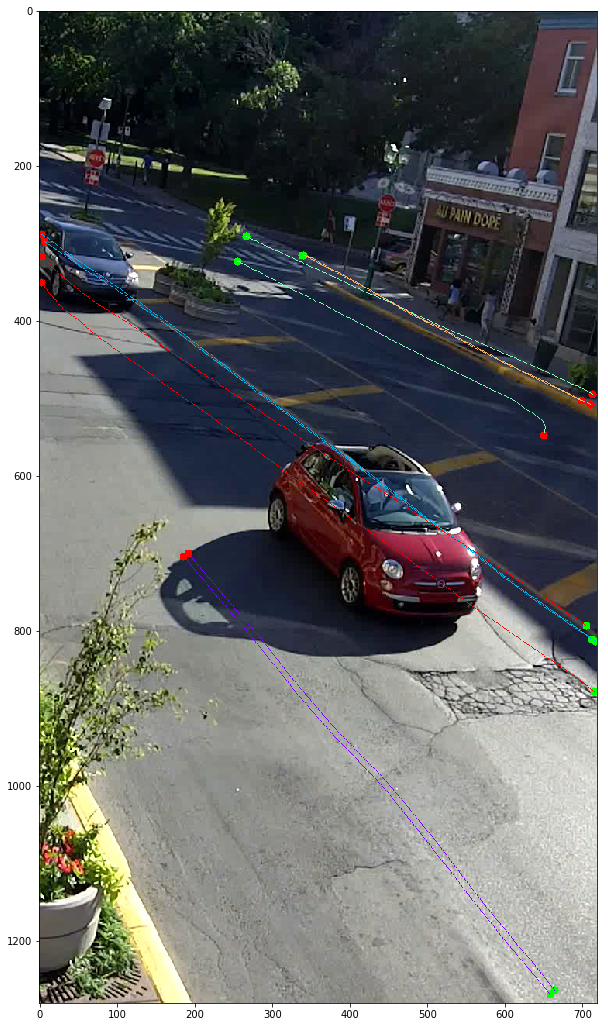

In [4]:
ut.plot_trajectories_by_groups(FRAME_PATH,pixel_trajectories_po)

## Get ground truth clusters

In [131]:
labels_true = ce.get_ground_truth(ids,ids_po)            

# Extract features

In [4]:
import time
s = time.time()
features = [ft.compute_features(trajectory) for trajectory in trajectories]
features = pd.DataFrame(ft.standardize_features(features))
print(time.time()-s)

0.357769966125


features.py:75: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  std_data = std_data.as_matrix()


In [5]:
import pandas as pd

features = pd.read_csv(SAVE_PATH+"extracted_features.csv")

# Compute distances

In [39]:
discretized_trajectories = [dtw.discretize(trajectory,0.1) for trajectory in trajectories]

In [40]:
distance_matrix = dtw.compute_dtw_distance_matrix(discretized_trajectories)

# Seq2seq

In [4]:
trajectories_X,ids_X,_ = db.get_trajectories_by_object(DATA_BASE)
#trajectories_X,ids_X = db.filter_trajectories(30, trajectories_X, ids_X)
trajectories_X = [t for o in trajectories_X for t in o]


In [5]:
trajectories_X = trajectories

In [8]:
import time
st = time.time()
diff_x,diff_y,diff_v,diff_r = s2s.extract_features(trajectories_X)
print(time.time()-st)

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
7.42219591141


In [18]:
import time
st = time.time()
X = [s2s.behavior_feature_extraction(diff_x[i],diff_y[i],diff_v[i],diff_r[i],window_size = 30) for i in range(len(diff_x))]
print(time.time()-st)

195.490707159


In [19]:
X = s2s.minmax_scale_append_eos(X)

In [8]:
pd.DataFrame(X).to_csv(SAVE_PATH+"seq2seq_X.csv")

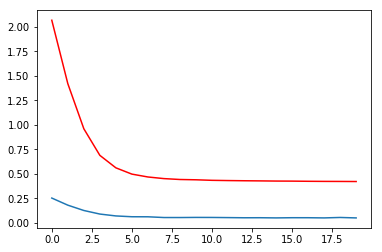

duration: 54.9473180771


In [20]:
encoder = s2s.seq2seq(X,hidden_size = 20)


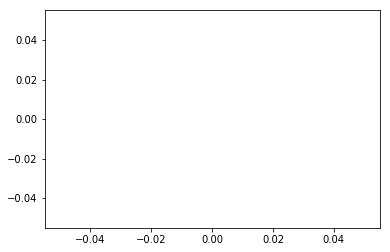

duration: 15.6210179329


In [22]:
encoder = s2s.seq2seq(X,hidden_size = 20,train_ = 0)

In [23]:
seq2seq_data = s2s.unify_trajectory_sizes(encoder,X)#seq2seq_data

In [7]:
import pandas as pd
seq2seq_data = pd.read_csv(SAVE_PATH+"seq2seq_50.csv")

## Clustering

In [8]:
from scipy.cluster.hierarchy import linkage, ward, fcluster
from scipy.spatial.distance import squareform
nb_clusters = nb_objects
Z = linkage(squareform(distance_matrix), 'ward')
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

NameError: name 'distance_matrix' is not defined

In [51]:
clusters = AgglomerativeClustering(n_clusters = 10).fit_predict(features)

In [5]:
from sklearn.cluster import KMeans
nb_clusters = 5
clusters = KMeans(n_clusters=nb_clusters, random_state=10).fit_predict(features)

In [ ]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.5, min_samples=5).fit_predict(data)

In [37]:
from sklearn.cluster import KMeans
nb_clusters = 4
#clusters = KMeans(n_clusters=nb_clusters, random_state=10).fit_predict(seq2seq_data)
clusters = AgglomerativeClustering(n_clusters = 4).fit_predict(seq2seq_data)

In [7]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 7+1))
ut.display_clusters_aao(clusters,VIDEO_PATH,pixel_trajectories,colors)

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import copy
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import pandas as pd
#import clustering
from numpy.linalg import inv



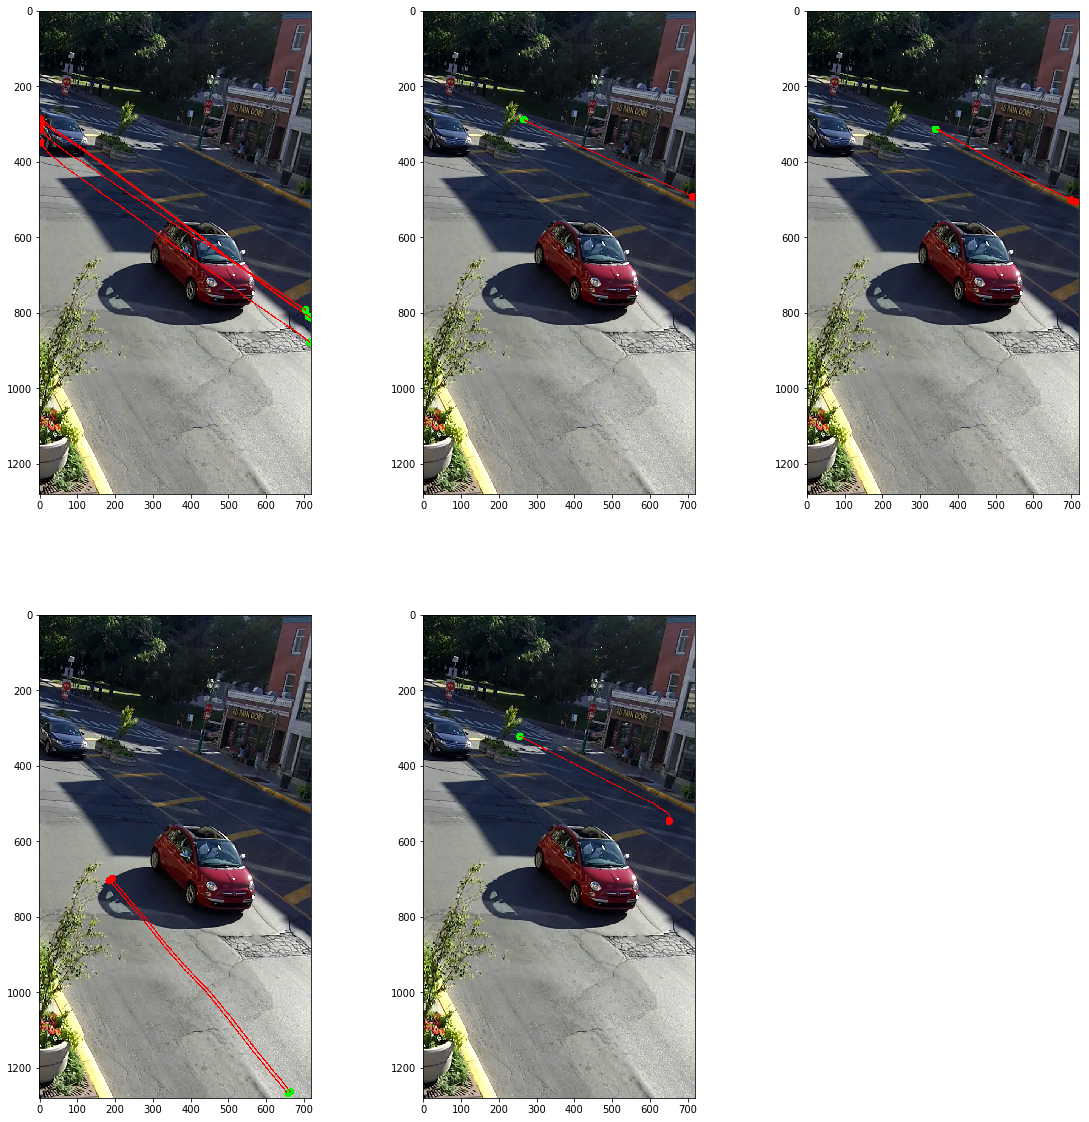

In [52]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

## Get stats on clusters

In [10]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,8),stats[:,0,0],yerr = stats[:,1,0])

float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero
float division by zero


# supervised clustering evaluation

In [134]:
from sklearn import metrics

print metrics.adjusted_mutual_info_score(labels_true,clusters)#ami
print metrics.adjusted_rand_score(labels_true, clusters)#ari
print metrics.homogeneity_completeness_v_measure(labels_true, clusters)#vmeasure

0.49181488719677746
0.3455919790075589
(0.5486183481819947, 0.7465901062923437, 0.6324743009021806)


## unsupervised clustering evaluation

In [28]:
from sklearn import metrics
def u_clustering_eval(max_clusters,algorithm,X):
    silhouette = []
    calinski_index = []
    for i in range(2,max_clusters):
        algorithm.set_params(n_clusters=i)
        clusters = algorithm.fit_predict(X)
        s = metrics.silhouette_score(X, clusters, metric='euclidean')
        c = metrics.calinski_harabaz_score(X, clusters) 
        silhouette.append(s)
        calinski_index.append(c)
    return silhouette, calinski_index

In [34]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

#algorithm = KMeans(random_state=10)
algorithm = AgglomerativeClustering()
#algorithme = GaussianMixture()

silhouette, calinski_index = u_clustering_eval(20,algorithm,seq2seq_data)

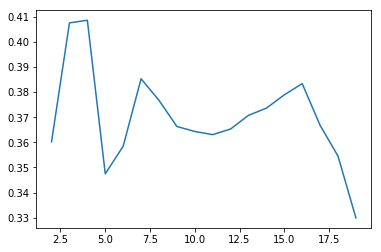

In [35]:
plt.plot(np.arange(2,20,1),silhouette)

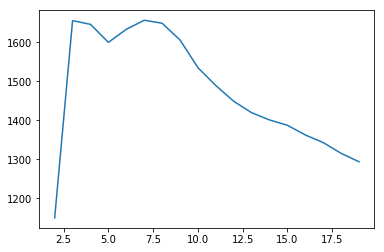

In [36]:
plt.plot(np.arange(2,20,1),calinski_index)